# Code by deepseek working properly

In [1]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from datetime import datetime, timedelta

# Initialize Faker
fake = Faker()

# Generate synthetic claims data
def generate_claims_data(num_records=500):
    data = []
    for _ in range(num_records):
        claim_id = fake.uuid4()
        claim_date = fake.date_between(start_date='-1y', end_date='today')
        insurer = fake.random_element(elements=('Insurer_A', 'Insurer_B', 'Insurer_C'))
        claim_amount = round(random.uniform(1000, 50000), 2)
        processing_days = random.randint(5, 60)  # Simulate delay (5=fast, 60=delayed)
        is_delayed = 1 if processing_days > 30 else 0  # Delayed if >30 days
        
        # Simulate notes (structured reasons for delays)
        notes = []
        if is_delayed:
            notes.append(fake.random_element(elements=(
                "Missing lab report", "Incomplete patient ID", 
                "No prior authorization", "Disputed diagnosis code"
            )))
        else:
            notes.append(fake.random_element(elements=(
                "All documents attached", "Quick approval", 
                "No issues found", "Clear documentation"
            )))
        
        data.append({
            "claim_id": claim_id,
            "claim_date": claim_date,
            "insurer": insurer,
            "claim_amount": claim_amount,
            "processing_days": processing_days,
            "is_delayed": is_delayed,
            "notes": " ".join(notes)
        })
    return pd.DataFrame(data)

# Generate sample data
claims_df = generate_claims_data(500)
claims_df.head()

,claim_id,claim_date,insurer,claim_amount,processing_days,is_delayed,notes
0,c6853798-8563-484b-b466-7748a3d67e31,2024-05-19,Insurer_A,10259.53,33,1,Disputed diagnosis code
1,e74eb342-2bd0-4947-a3ab-efffd07e1e48,2025-02-28,Insurer_C,36046.57,55,1,No prior authorization
2,94b2e264-c14e-45c7-86c8-2a4aa7efd9b0,2024-08-27,Insurer_A,40975.68,6,0,No issues found
3,a1af657c-b896-4886-b603-076dfe1e70df,2024-05-27,Insurer_A,17242.42,19,0,Quick approval
4,3136ca39-6b8a-4fa5-9b13-d3d5a82e5d0f,2025-04-23,Insurer_A,31380.68,30,0,No issues found


In [6]:

# ----------------------------
# Step 2: Feature Engineering
# ----------------------------
# Extract features from notes using TF-IDF (NLP)
tfidf = TfidfVectorizer(max_features=50, stop_words='english')
notes_tfidf = tfidf.fit_transform(claims_df['notes'])
notes_df = pd.DataFrame(notes_tfidf.toarray(), columns=tfidf.get_feature_names_out())
# print(notes_df.head())
# Add other features
claims_df['days_since_claim'] = (pd.to_datetime('today') - pd.to_datetime(claims_df['claim_date'])).dt.days
claims_processed = pd.concat([
    claims_df[['primary_company', 'claim_amount', 'days_since_claim', 'processing_days', 'is_fraud']],
    notes_df
], axis=1)

# Encode categorical (insurance company)
claims_processed = pd.get_dummies(claims_processed, columns=['primary_company'])

# claims_df


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Convert dates to days since claim
claims_df['days_since_claim'] = (pd.to_datetime('today') - pd.to_datetime(claims_df['claim_date'])).dt.days

# One-hot encode insurers
claims_processed = pd.get_dummies(claims_df, columns=['insurer'])

# Extract features from notes using TF-IDF (NLP)
tfidf = TfidfVectorizer(max_features=20, stop_words='english')  # Top 20 keywords
notes_tfidf = tfidf.fit_transform(claims_processed['notes'])
notes_df = pd.DataFrame(notes_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Combine all features
X = pd.concat([claims_processed[['claim_amount', 'days_since_claim', 
                               'insurer_Insurer_A', 'insurer_Insurer_B', 'insurer_Insurer_C']], 
              notes_df], axis=1)
y = claims_processed['is_delayed']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

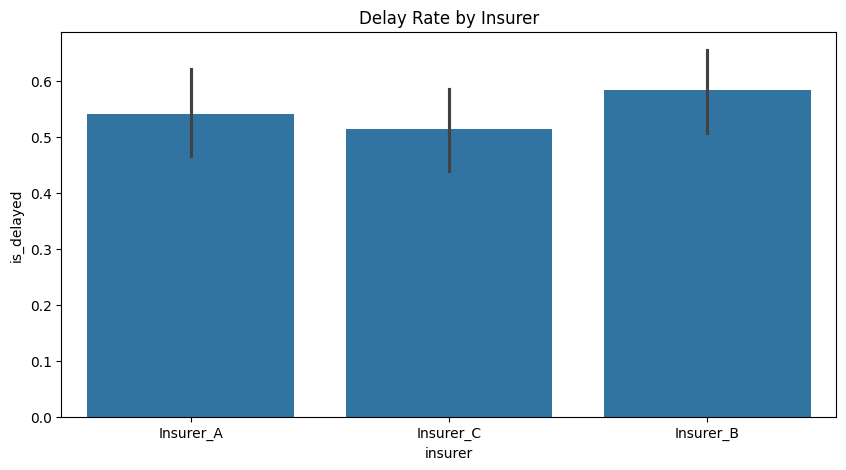

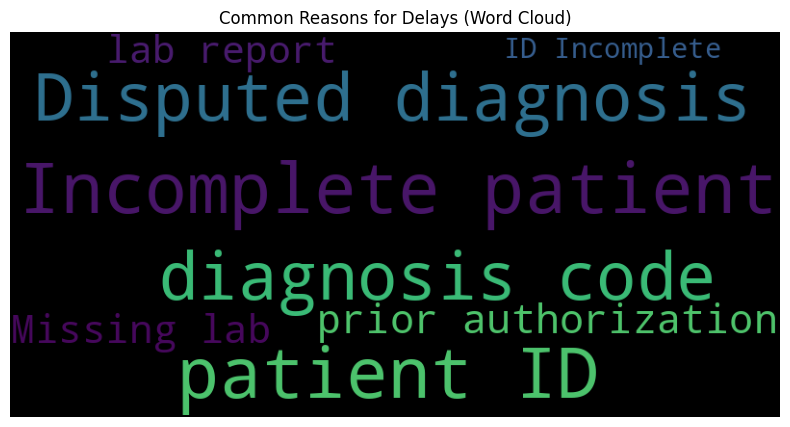

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot delay rate by insurer
plt.figure(figsize=(10, 5))
sns.barplot(x='insurer', y='is_delayed', data=claims_df)
plt.title("Delay Rate by Insurer")
plt.show()

# Word cloud for notes (requires `wordcloud` library)
from wordcloud import WordCloud

delayed_notes = " ".join(claims_df[claims_df['is_delayed'] == 1]['notes'])
wordcloud = WordCloud(width=800, height=400).generate(delayed_notes)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Common Reasons for Delays (Word Cloud)")
plt.show()

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train model
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature importance (critical variables)
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop Delay Drivers:")
print(feature_importance.head(10))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        89

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150


Top Delay Drivers:
          feature  importance
16         issues    0.105651
7   authorization    0.082545
20          prior    0.070460
22         report    0.058562
10      diagnosis    0.057209
15     incomplete    0.056918
19        patient    0.055417
12  documentation    0.054273
6        attached    0.052925
18        missing    0.051885


In [14]:
# 5. Generate Actionable Insights (Corrected)
print("\nRecommended Interventions:")
for driver in feature_importance.head(5)['feature'].tolist():
    if 'insurer_' in driver:
        insurer = driver.split('_')[1]
        print(f"- Renegotiate terms with {insurer} (high delay rate).")
    elif 'claim_amount' in driver:
        print("- Require additional docs for claims over $20,000.")
    elif driver in tfidf.get_feature_names_out().tolist():  # Check if keyword exists
        print(f"- Auto-flag claims with '{driver}' in notes for review.")


Recommended Interventions:
- Auto-flag claims with 'issues' in notes for review.
- Auto-flag claims with 'authorization' in notes for review.
- Auto-flag claims with 'prior' in notes for review.
- Auto-flag claims with 'report' in notes for review.
- Auto-flag claims with 'diagnosis' in notes for review.


In [15]:
def predict_delay(new_claim):
    # Preprocess new claim
    new_claim_processed = pd.DataFrame({
        'claim_amount': [new_claim['claim_amount']],
        'days_since_claim': [(datetime.today() - new_claim['claim_date']).days],
        'insurer_Insurer_A': [1 if new_claim['insurer'] == 'Insurer_A' else 0],
        'insurer_Insurer_B': [1 if new_claim['insurer'] == 'Insurer_B' else 0],
        'insurer_Insurer_C': [1 if new_claim['insurer'] == 'Insurer_C' else 0]
    })
    
    # Add TF-IDF features from notes
    notes_tfidf = tfidf.transform([new_claim['notes']])
    notes_df = pd.DataFrame(notes_tfidf.toarray(), columns=tfidf.get_feature_names_out())
    
    # Combine features
    new_data = pd.concat([new_claim_processed, notes_df], axis=1)
    
    # Predict
    delay_prob = model.predict_proba(new_data)[0][1]
    return delay_prob

# Example new claim
new_claim = {
    'claim_amount': 45000,
    'claim_date': datetime(2024, 5, 1),
    'insurer': 'Insurer_A',
    'notes': "diagnosis needs review missing lab report"
}

delay_risk = predict_delay(new_claim)
print(f"Delay Risk: {delay_risk:.0%} → {'Review Needed' if delay_risk > 0.5 else 'Auto-Approve'}")

Delay Risk: 100% → Review Needed
